In [48]:
# Input the name of the file for analysis here
# I will want to make this take more than one file at a time
SEQUENCE_FILE = "NP-11-19-5-merged.fastq"
FILE_NAME = str(SEQUENCE_FILE.split('.')[0])

from Bio import SeqIO

#this is the template for alignment and should be a fasta file with only one sequence in it
templateParsed = SeqIO.parse('rbcL_codonopt_barcoded.txt', 'fasta')
TEMPLATE_STRING = None
for record in templateParsed:
    assert TEMPLATE_STRING == None
    TEMPLATE_STRING = str(record.seq)
    RCtemplateString = record.seq.reverse_complement()
    TEMPLATE_TRANSLATION = str(record.seq.translate(to_stop=True))

# This is the length of sequence in the read used to align it to the template
SEARCH_MOTIF_LENGTH = 11

# Quality cutoff parameters
# If the average quality dips below this I throw out the pair of reads
AVG_PHRED_CUTOFF = 25
# If there are more bad single nucleotide reads than this cutoff I also throw the reads out
LETTER_QUALITY_CUTOFF = 20
BAD_BASES_ALLOWED = 5
# The 5'-most and 3'-most bases in the read are prone to low quality so trimming the first and last AAs is good practice
NTERMINAL_AAs_TO_TRIM = 1
CTERMINAL_AAs_TO_TRIM = 1
BARCODE_LENGTH = 15


# These dummy values work great for the pie chart but they have a bad effect on the histograms
DUMMY_MUTATION = 'X0X'
DUMMY_BARCODE = 'NNNNN'
DUMMY_CODON = 'NNN'
DUMMY_TRANSLATION = 'XXX'
DUMMY_TEMPLATE_AA = 'X'

# This is the FULL sequence between the barcode and the last coding nucleotide (including stop codons)
BARCODE_FLANK = 'CCTGCAGGCTATTA'

# This is the list of allowed mutations
PROGRAMMED_MUTATION_CODONS = ['CGT','CAT','AAA','GAT','GAA','AGC','ACC','AAT',
                              'CAG','TGC','GGC','CCG','GCG','GTG','ATT','CTG','ATG','TTT', 'TAT', 'TGG']




/opt/anaconda3/envs/NP_11_dataAnalysis/lib/python3.7/site-packages/Bio/Seq.py:2742: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


In [49]:
# This function processes a SeqIO file into a series of lists that can go into a dictionary

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import itertools
import math
import pandas as pd
import time



def countBadReads(qualityScores):
    badReads = 0
    for qualityScore in qualityScores:
        if qualityScore < LETTER_QUALITY_CUTOFF:
            badReads += 1
    return badReads

def processRecord(timers, rec, sequences, AVGphredQ, basesWphredQunderCutoff, translations, barcodePresence,
                  barcodeList, nonBarcodeReadAlignment, mutation, mutCodon, allowedMut, numberOfMutations, readIDs = None):
    
    
    if readIDs is not None:
        readIDs.append(rec.name)
    sequences.append(str(rec.seq))
    
    qualityStartTime = time.perf_counter()
    
    AVGphredQ.append(np.mean(rec.letter_annotations['phred_quality']))
    basesWphredQunderCutoff.append(countBadReads(rec.letter_annotations['phred_quality']))

    timers['qualityTime'] += time.perf_counter() - qualityStartTime
    mutStartTime = time.perf_counter()
    
    mutant = DUMMY_MUTATION
    mutationCounter = 0
    mutationCodon = DUMMY_CODON
    mutationDNAlocation = 0
    barcodeToAppend = DUMMY_BARCODE
    aaSeq = DUMMY_TRANSLATION
    barcodeStart = rec.seq.find(BARCODE_FLANK)
    barcodeBool = False
    translationStart = -1
    codingSequence = None
    allowedMutBool = False
    nonBarcodeReadStart = -1
    templateAminoAcid = DUMMY_TEMPLATE_AA
    
    # This finds barcodes and translations and accounts for frame
    if barcodeStart != -1:
        barcodeToAppend = str(rec.seq[barcodeStart - BARCODE_LENGTH:barcodeStart])
        if barcodeToAppend != '' and barcodeToAppend != None and len(barcodeToAppend) == BARCODE_LENGTH:
            barcodeBool = True
        else:
            barcodeToAppend = DUMMY_BARCODE
        stopCodonPosition = barcodeStart + len(BARCODE_FLANK)
        lenOfCodingSequence = len(rec.seq) - stopCodonPosition
        lengthInFrame = lenOfCodingSequence - (lenOfCodingSequence % 3)
        translationStart = len(TEMPLATE_TRANSLATION) - (lengthInFrame // 3)
        codingSequence = (rec.seq[stopCodonPosition:stopCodonPosition + lengthInFrame].reverse_complement())

    else:
        # This extracts the location and aa sequence in a read without a barcode and accounts for frame
        nonBarcodeReadStart = TEMPLATE_STRING.find(str(rec.seq[:SEARCH_MOTIF_LENGTH])) 
        if nonBarcodeReadStart != -1:
            frame = nonBarcodeReadStart % 3
            translationStart = nonBarcodeReadStart // 3 + 1 
            codingSequence = rec.seq[3 - frame:] 
    
    if codingSequence != None:
        aaSeq = codingSequence.translate(to_stop = True)
        # Find mutations in translation
        for position, aminoAcid in enumerate(aaSeq):
            if translationStart + position < len(TEMPLATE_TRANSLATION):
                templateAminoAcid = TEMPLATE_TRANSLATION[translationStart + position]
            if aaSeq != DUMMY_TRANSLATION and \
                        aminoAcid != templateAminoAcid and \
                        position >= NTERMINAL_AAs_TO_TRIM and \
                        position <= len(aaSeq) - CTERMINAL_AAs_TO_TRIM:
                templateAAIndex = translationStart + position
                # The + 1 in the mutant name just makes the amino acid correct in biological notation
                mutant = str(templateAminoAcid) + str(templateAAIndex + 1) + str(aminoAcid)
                mutationDNAlocation = templateAAIndex * 3
                mutationCodon = str(codingSequence[mutationDNAlocation - (translationStart * 3) : \
                                               mutationDNAlocation - (translationStart * 3) + 3])
                if mutationCodon in PROGRAMMED_MUTATION_CODONS:
                    allowedMutBool = True
                else:
                    allowedMutBool = False
                mutationCounter += 1
                
    timers['timeSpentAddingMutations'] += time.perf_counter() - mutStartTime
    

            
    translations.append(str(aaSeq))
    barcodePresence.append(barcodeBool)
    barcodeList.append(barcodeToAppend)
    nonBarcodeReadAlignment.append(nonBarcodeReadStart)
    mutation.append(mutant)
    mutCodon.append(mutationCodon)
    allowedMut.append(allowedMutBool)
    numberOfMutations.append(mutationCounter)
    


In [50]:
# Here I can import any fastq file with reads
mockDataParsed = SeqIO.parse(SEQUENCE_FILE, "fastq")

readIDs = []
sequences1 = []
sequences2 = []
translations1 = []
translations2 = []
AVGphredQ1 = []
AVGphredQ2 = []
basesWphredQunderCutoff1 = []
basesWphredQunderCutoff2 = []
barcodePresence1 = []
barcodePresence2 = []
nonBarcodeReadAlignment1 = []
nonBarcodeReadAlignment2 = []
barcodeList1 = []
barcodeList2 = []
barcodeConsensus = []
barcodeAppearances = []
mutation1 = []
mutation2 = []
mutCodon1 = []
mutCodon2 = []
singleMutation = []
mutationAppearances = []
allowedMut1 = []
allowedMut2 = []
allowedMut = []
singMutCodon = []
numberOfMutations1 = []
numberOfMutations2 = []
highQuality = []

#I'm going to put paired reads into the same row in this dictionary
#The file will have to have an even number of reads for this


startTime = time.perf_counter()

timers = {'qualityTime' : 0.0, 'timeSpentAddingMutations' : 0.0}


for rec1, rec2 in itertools.zip_longest(mockDataParsed, mockDataParsed): 
    processRecord(timers, rec1, sequences1, AVGphredQ1, basesWphredQunderCutoff1, translations1, 
                  barcodePresence1, barcodeList1, nonBarcodeReadAlignment1, mutation1, mutCodon1,
                  allowedMut1, numberOfMutations1, readIDs)
    processRecord(timers, rec2, sequences2, AVGphredQ2, basesWphredQunderCutoff2, translations2, 
                  barcodePresence2, barcodeList2, nonBarcodeReadAlignment2, mutation2, mutCodon2,
                  allowedMut2, numberOfMutations2)

print(timers)

    
# Combine the barcodes into one row when there is one barcode
for read, barcode in enumerate(barcodeList1):
    barcodeConsensus.append(barcode)
for read, barcode in enumerate(barcodeList2):
    if barcodeConsensus[read] != DUMMY_BARCODE and barcode != DUMMY_BARCODE:
        barcodeConsensus[read] = DUMMY_BARCODE
    if barcode != DUMMY_BARCODE:
        barcodeConsensus[read] = barcode

# Combine the mutations and their codons into two columns when there is one mutation
# Check if single codon is allowed in a third column
# This works by checking if there's a single change in either of the paired reads and updating accordingly
# Importantly for later, if there is an unallowed single mutant it will get added to the single mutant column
for read, mutation in enumerate(mutation1):
    singleMutation.append(DUMMY_MUTATION)
    singMutCodon.append(DUMMY_CODON)
    allowedMut.append(False)
    if mutation1[read] != DUMMY_MUTATION and mutation2[read] == DUMMY_MUTATION:
        singleMutation[read] = mutation1[read]
        singMutCodon[read] = str(mutCodon1[read])
        if str(mutCodon1[read]) in PROGRAMMED_MUTATION_CODONS:
            allowedMut[read] = True
    if mutation1[read] == DUMMY_MUTATION and mutation2[read] != DUMMY_MUTATION:
        singleMutation[read] = mutation2[read]
        singMutCodon[read] = str(mutCodon2[read])
        if str(mutCodon2[read]) in PROGRAMMED_MUTATION_CODONS:
            allowedMut[read] = True
    if numberOfMutations1[read] + numberOfMutations2[read] > 1 or \
            mutation1[read] != DUMMY_MUTATION and mutation2[read] != DUMMY_MUTATION:
        singleMutation[read] = 'More than one'
        singMutCodon[read] = DUMMY_CODON
        allowedMut[read] = False
    if mutation1[read] == DUMMY_MUTATION and mutation2[read] == DUMMY_MUTATION:
        singleMutation[read] = DUMMY_MUTATION
        singMutCodon[read] = DUMMY_CODON
        allowedMut[read] = False
        
# Indicate if quality is sufficient
for read, quality in enumerate(AVGphredQ1):
    if AVGphredQ1[read] < AVG_PHRED_CUTOFF or \
        AVGphredQ1[read] < AVG_PHRED_CUTOFF or \
        basesWphredQunderCutoff1[read] > BAD_BASES_ALLOWED or \
        basesWphredQunderCutoff2[read] > BAD_BASES_ALLOWED:
        highQuality.append(False)
    else:
        highQuality.append(True)
        
# These modules would add in additional columns that count instances of each barcode and mutation    
    
# # Count instances of a barcode
# for read, barcode in enumerate(barcodeConsensus):
#     if barcode != DUMMY_BARCODE:
#         barcodeAppearances.append(int(barcodeConsensus.count(barcode)))
#     else:
#         barcodeAppearances.append(None)
        
# # Count instances of a mutation
# for read, mutation in enumerate(singleMutation):
#     if mutation != DUMMY_MUTATION and mutation != 'More than one':
#         mutationAppearances.append(int(singleMutation.count(mutation)))
#     else:
#         mutationAppearances.append(None)
        
untrimmed_data = {
    'Read ID': readIDs,
#     'Sequence1': sequences1,
#     'Sequence2': sequences2,
#     'translation1': translations1,
#     'translation2': translations2,
#     'Average phredQ1': AVGphredQ1,
#     'Average phredQ2': AVGphredQ2,
#     'Number of bases with phredQ under {} read 1'.format(LETTER_QUALITY_CUTOFF): basesWphredQunderCutoff1,
#     'Number of bases with phredQ under {} read 2'.format(LETTER_QUALITY_CUTOFF): basesWphredQunderCutoff2,
    'High quality read pair' : highQuality,
#     'Is there a barcode in read 1?' : barcodePresence1,
#     'Is there a barcode in read 2?' : barcodePresence2,
#     'Nonbarcode read start position1' : nonBarcodeReadAlignment1,
#     'Nonbarcode read start position2' : nonBarcodeReadAlignment2,
#     'Barcode sequence1' : barcodeList1,
#     'Barcode sequence2' : barcodeList2,
    'Barcode' : barcodeConsensus,
#     'Barcode appearances' : barcodeAppearances,
#     'Mutation1' : mutation1,
#     'Mutation2' : mutation2,
    'Single mutation' : singleMutation,
#     'Mutation appearances' : mutationAppearances,
#     'Mutations in read 1' : numberOfMutations1,
#     'Mutations in read 2' : numberOfMutations2,
#     'Mutated codon 1' : mutCodon1,
#     'Mutated codon 2' : mutCodon2,
    'Single mutation codon' : singMutCodon,
#     'Allowed mutation1' : allowedMut1,
#     'Allowed mutation2' : allowedMut2,
    'Allowed single mutation' : allowedMut
    }

dfRaw = pd.DataFrame(untrimmed_data)
dfRaw.to_csv(FILE_NAME + '_processed_df.csv')

print('finished adding to dataframe: ' + str(time.perf_counter() - startTime) + ' seconds')

dfRaw.head(50)



{'qualityTime': 112.69542066818576, 'timeSpentAddingMutations': 270.80390751175855}
finished adding to dataframe: 485.26759312600007 seconds


,Read ID,High quality read pair,Barcode,Single mutation,Single mutation codon,Allowed single mutation
0,FS10000719:32:BPC29518-1720:1:1101:1040:1000,True,ACCTACCACAGATCT,X0X,NNN,False
1,FS10000719:32:BPC29518-1720:1:1101:1210:1000,True,GTTTGCAAGTGTACT,X0X,NNN,False
2,FS10000719:32:BPC29518-1720:1:1101:1220:1000,True,CCATACATCAGATCT,X0X,NNN,False
3,FS10000719:32:BPC29518-1720:1:1101:1230:1000,True,GGTCAGCGCAACGAA,X0X,NNN,False
4,FS10000719:32:BPC29518-1720:1:1101:1290:1000,True,GTGAGGCGTGGCACT,X0X,NNN,False
5,FS10000719:32:BPC29518-1720:1:1101:1370:1000,True,CCTACATATGGAACT,X0X,NNN,False
6,FS10000719:32:BPC29518-1720:1:1101:1440:1000,True,ATAGACCGTGCGGTG,X0X,NNN,False
7,FS10000719:32:BPC29518-1720:1:1101:1580:1000,True,GCACCCTTCCACACT,X0X,NNN,False
8,FS10000719:32:BPC29518-1720:1:1101:1590:1000,False,TAAGTGAAAAAATGC,G384V,GTT,False
9,FS10000719:32:BPC29518-1720:1:1101:1620:1000,False,CGTATTCAATAACTG,X0X,NNN,False


Total reads: 1287697
Total reads with barcode: 1223071
Low quality reads: 226475
High quality reads with no barcode: 26308
High quality with barcode no mutations (WT): 835367
High quality with barcode multiple mutations: 25692
High quality with barcode and one allowed mutation: 144581
High quality with barcode and one unallowed mutation: 29274


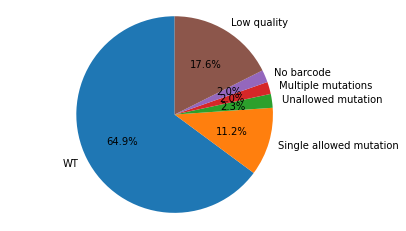

In [51]:
# Make dataframes with subsets
# dfAllowedSingle is the dataframe we will want to be the biggest at the end

totalCounts = str(len(dfRaw))

barcodeFound = dfRaw[np.not_equal(dfRaw['Barcode'],(DUMMY_BARCODE))]

highQCheck = dfRaw['High quality read pair'] == True
barcodeCheck = dfRaw['Barcode'] != DUMMY_BARCODE
WTCheck = dfRaw['Single mutation'] == DUMMY_MUTATION
singleMutCheck = (dfRaw['Single mutation'] != 'More than one') & (dfRaw['Single mutation'] != DUMMY_MUTATION)
multMutCheck = dfRaw['Single mutation'] == 'More than one'
allowedCheck = dfRaw['Allowed single mutation'] == True

dfHighQ = dfRaw[highQCheck]
dfBC = dfRaw[barcodeCheck]
dfHQBC = dfRaw[highQCheck & barcodeCheck]
dfLowQ = dfRaw[~highQCheck]
dfHQNoBC = dfRaw[highQCheck & ~barcodeCheck]
dfHQBCWT = dfRaw[highQCheck & barcodeCheck & WTCheck]
dfHQmult = dfRaw[highQCheck & barcodeCheck & multMutCheck]
dfUnallowedSingle = dfRaw[highQCheck & barcodeCheck & singleMutCheck & ~allowedCheck]
dfAllowedSingle = dfRaw[highQCheck & barcodeCheck & singleMutCheck & allowedCheck]

lowQCounts = len(dfLowQ)
howManyBarcodesFound = len(dfBC)
noBarcodeCounts = len(dfHQNoBC)
WTcounts = len(dfHQBCWT)
multMutCounts = len(dfHQmult)
SMallowedCounts = len(dfAllowedSingle)
SMunallowedCounts = len(dfUnallowedSingle)

print('Total reads: ' + totalCounts)
print('Total reads with barcode: ' + str(howManyBarcodesFound))
print('Low quality reads: ' + str(lowQCounts))
print('High quality reads with no barcode: ' + str(noBarcodeCounts))
print('High quality with barcode no mutations (WT): ' + str(WTcounts))
print('High quality with barcode multiple mutations: ' + str(multMutCounts))
print('High quality with barcode and one allowed mutation: ' + str(SMallowedCounts))
print('High quality with barcode and one unallowed mutation: ' + str(SMunallowedCounts))

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'WT', 'Single allowed mutation', 'Unallowed mutation', 'Multiple mutations', 'No barcode', 'Low quality'
sizes = [WTcounts, SMallowedCounts, SMunallowedCounts, multMutCounts, noBarcodeCounts, lowQCounts]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(FILE_NAME + '_readtypePieChart.pdf')

1223071
112718


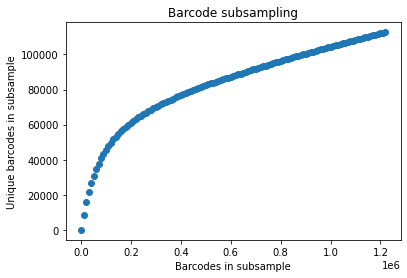

In [52]:
# This is a graph subsampling the barcodes looking for uniques
# This takes a long time to run, might need to edit for larger datasets
cumulativeBarcodes = []
uniqueBarcodes = []
howOftenToSample = 10000
print(dfBC['Barcode'][:].count())
print(len(dfBC['Barcode'][:].value_counts()))
for read, barcode in enumerate(dfBC['Barcode'][:]):
    if read % howOftenToSample == 0:
        cumulativeBarcodes.append(dfBC['Barcode'][:read].count())
        uniqueBarcodes.append(len(dfBC['Barcode'][:read].value_counts()))

plt.scatter(cumulativeBarcodes, uniqueBarcodes)
plt.title('Barcode subsampling')
plt.xlabel('Barcodes in subsample')
plt.ylabel('Unique barcodes in subsample')
plt.savefig(FILE_NAME + '_barcodeSubsampling.pdf')

    

Total reads: 
1287697
Total unique barcodes: 
112718
Total unique barcodes in high quality reads: 
81102


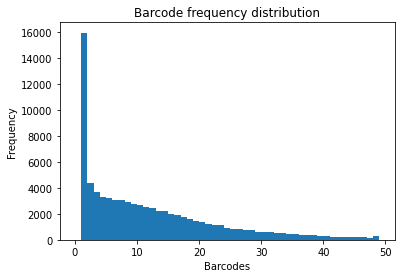

In [53]:
# Total reads
print('Total reads: ')
print(str(len(dfRaw)))

# Total unique barcodes
print('Total unique barcodes: ')
print(str(len(dfBC['Barcode'].value_counts())))
# print(dfBC['Barcode'].value_counts())

# Unique barcodes in high quality reads
print('Total unique barcodes in high quality reads: ')
print(str(len(dfHQBC['Barcode'].value_counts())))
plt.hist(dfHQBC['Barcode'].value_counts(), bins = range(0,50,1))
plt.title('Barcode frequency distribution')
plt.xlabel('Barcodes')
plt.ylabel('Frequency')
plt.savefig(FILE_NAME + '_uniqueBarcodesHist.pdf')

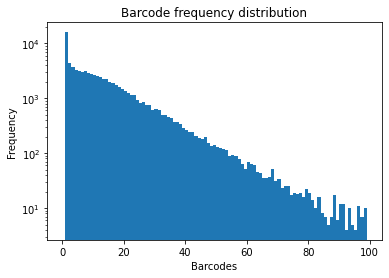

In [54]:
# This is a histogram of how often each barcode appears on a log scale
# I include all barcodes here irrespective of mutations, allowed or otherwise
plt.hist(dfHQBC['Barcode'].value_counts(), bins = range(0,100,1))
plt.yscale('log')
plt.title('Barcode frequency distribution')
plt.xlabel('Barcodes')
plt.ylabel('Frequency')
plt.savefig(FILE_NAME + '_totalBarcodeDist.pdf')

Total reads with allowed mutations (also high quality and with a barcode): 
144581
Total unique allowed mutations in high quality reads with barcodes: 
1195
Mutation frequency distribution: 


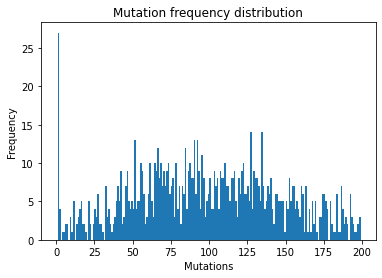

In [55]:
# Unique allowed mutations in reads with barcodes and high quality reads
# (this includes "none" and "multiple" as values)
print('Total reads with allowed mutations (also high quality and with a barcode): ')
print(str(len(dfAllowedSingle)))
print('Total unique allowed mutations in high quality reads with barcodes: ')
print(str(len(dfAllowedSingle['Single mutation'].value_counts())))
print('Mutation frequency distribution: ')
plt.hist(dfAllowedSingle['Single mutation'].value_counts(), bins = range(0,200,1))
plt.title('Mutation frequency distribution')
plt.xlabel('Mutations')
plt.ylabel('Frequency')
plt.savefig(FILE_NAME + '_uniqueMutationsHist.pdf')

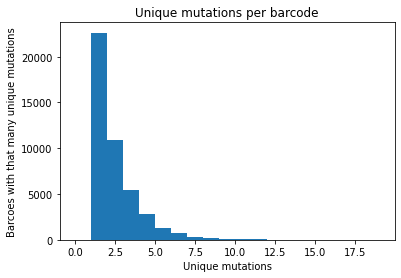

In [56]:
# This is a histogram of how many unique mutations each barcode has
MutsPerBarc = dfAllowedSingle.groupby('Barcode')['Single mutation'].nunique()
plt.hist(MutsPerBarc, bins = range(0,20,1))
plt.title('Unique mutations per barcode')
plt.xlabel('Unique mutations')
plt.ylabel('Barcoes with that many unique mutations')
plt.savefig(FILE_NAME + '_uniqueMutationsPerBarcode.pdf')

In [97]:
# Look at unique mutations for given barcodes
# Focus on barcodes with many mutations at first to get a sense of the distribution

mutsPerBC = 19

dfAllowedSingle['Unique mutations'] = dfAllowedSingle.groupby(['Barcode'])['Single mutation'].transform('nunique')
onlyMulMutCheck = dfAllowedSingle['Unique mutations'] == mutsPerBC
dfOnlyMults = dfAllowedSingle[onlyMulMutCheck]


print('The number of reads with barcodes that have ' + str(mutsPerBC) + ' mutations is: ' + \
      str(len(dfOnlyMults['Barcode'])))
print('The number of barcodes with ' + str(mutsPerBC) + ' mutations is: ' + str(len(dfOnlyMults['Barcode'].value_counts())))


dfOnlyMults.groupby('Single mutation').head(50)



The number of reads with barcodes that have 19 mutations is: 39
The number of barcodes with 19 mutations is: 1


/opt/anaconda3/envs/NP_11_dataAnalysis/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Read ID,High quality read pair,Barcode,Single mutation,Single mutation codon,Allowed single mutation,Unique mutations
12982,FS10000719:32:BPC29518-1720:1:1101:15660:1510,True,CTACGGACGGGGATT,A386I,ATT,True,19
638385,FS10000719:32:BPC29518-1720:1:1108:10730:3700,True,CTACGGACGGGGATT,A386I,ATT,True,19
655099,FS10000719:32:BPC29518-1720:1:1109:3290:1280,True,CTACGGACGGGGATT,A386I,ATT,True,19
668720,FS10000719:32:BPC29518-1720:1:1109:16440:1800,True,CTACGGACGGGGATT,G394A,GCG,True,19
850503,FS10000719:32:BPC29518-1720:1:1111:3270:2770,True,CTACGGACGGGGATT,A386S,AGC,True,19
905014,FS10000719:32:BPC29518-1720:1:1112:9370:1760,True,CTACGGACGGGGATT,E381I,ATT,True,19
909018,FS10000719:32:BPC29518-1720:1:1112:8050:1920,True,CTACGGACGGGGATT,A386I,ATT,True,19
1009309,FS10000719:32:BPC29518-1720:1:1113:14000:2660,True,CTACGGACGGGGATT,G358W,TGG,True,19
637442,FS10000719:32:BPC29518-1720:1:1108:14350:3660,True,CTACGGACGGGGATT,T460I,ATT,True,19
1023873,FS10000719:32:BPC29518-1720:1:1113:13390:3220,True,CTACGGACGGGGATT,R452F,TTT,True,19


In [113]:
# Look at barcodes with 2 mutations - Is one of them usually dominant?

mutsPerBC = 2

dfAllowedSingle['Unique mutations'] = dfAllowedSingle.groupby(['Barcode'])['Single mutation'].transform('nunique')
dfAllowedSingle['Barcode occurences'] = dfAllowedSingle.groupby(['Barcode'])['Read ID'].transform('nunique')


onlyMulMutCheck = dfAllowedSingle['Unique mutations'] == mutsPerBC
dfOnlyMults = dfAllowedSingle[onlyMulMutCheck].sort_values('Barcode').sort_values('Barcode occurences', ascending = False)


print('The number of reads with barcodes that have ' + str(mutsPerBC) + ' mutations is: ' + \
      str(len(dfOnlyMults['Barcode'])))

# dfOnlyMults['Barcode frequency count'] = dfOnlyMults.groupby('Barcode')['Barcode'].transform(pd.Series.value_counts)
# dfOnlyMults.sort_values('Barcode frequency count', ascending=False)

dfOnlyMults.head(50)

/opt/anaconda3/envs/NP_11_dataAnalysis/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/NP_11_dataAnalysis/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


The number of reads with barcodes that have 2 mutations is: 36188


,Read ID,High quality read pair,Barcode,Single mutation,Single mutation codon,Allowed single mutation,Unique mutations,Barcode occurences
28683,FS10000719:32:BPC29518-1720:1:1101:6880:2130,True,GATTACGGCATGTGA,A463N,AAT,True,2,93
1071117,FS10000719:32:BPC29518-1720:1:1114:2860:1930,True,GATTACGGCATGTGA,A463N,AAT,True,2,93
572948,FS10000719:32:BPC29518-1720:1:1108:14130:1080,True,GATTACGGCATGTGA,A463N,AAT,True,2,93
418672,FS10000719:32:BPC29518-1720:1:1106:11560:1340,True,GATTACGGCATGTGA,A463N,AAT,True,2,93
943066,FS10000719:32:BPC29518-1720:1:1112:8080:3220,True,GATTACGGCATGTGA,A463N,AAT,True,2,93
1166622,FS10000719:32:BPC29518-1720:1:1115:5610:2460,True,GATTACGGCATGTGA,A463N,AAT,True,2,93
639972,FS10000719:32:BPC29518-1720:1:1108:4170:3770,True,GATTACGGCATGTGA,A463N,AAT,True,2,93
1225751,FS10000719:32:BPC29518-1720:1:1116:9380:1610,True,GATTACGGCATGTGA,A463N,AAT,True,2,93
610019,FS10000719:32:BPC29518-1720:1:1108:13620:2550,True,GATTACGGCATGTGA,A463N,AAT,True,2,93
456100,FS10000719:32:BPC29518-1720:1:1106:7470:2840,True,GATTACGGCATGTGA,A463N,AAT,True,2,93


In [60]:
# Generate lookup table between barcode and mutant for barcodes with only one mutation
# First add a column that counts unique mutations for a given barcode
# Then remove barcodes with more than one muation
# Generate a lookup table

dfAllowedSingle['Unique mutations'] = dfAllowedSingle.groupby(['Barcode'])['Single mutation'].transform('nunique')

onlyUniqueCheck = dfAllowedSingle['Unique mutations'] == 1
dfOnlyUniques = dfAllowedSingle[onlyUniqueCheck]

print('The number of reads with barcodes that have only one mutation is: ' + \
      str(len(dfOnlyUniques['Barcode'])))

print('The number of barcodes with one mutation is: ' + str(len(dfOnlyUniques['Barcode'].value_counts())))
print('The number of mutations that this covers is: ' + str(len(dfOnlyUniques['Single mutation'].value_counts())))

dfOnlyUniques.to_csv(FILE_NAME + '_lookup_table.csv', columns = ['Barcode','Single mutation'])

The number of reads with barcodes that have only one mutation is: 43701
The number of barcodes with one mutation is: 22616
The number of mutations that this covers is: 1161


/opt/anaconda3/envs/NP_11_dataAnalysis/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1490
664
8


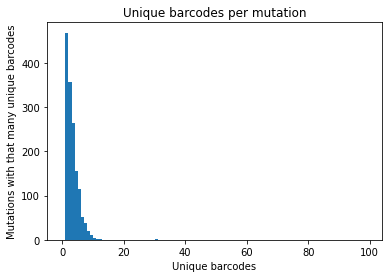

In [12]:
# This is a histogram of how many unique barcodes each mutation has
# I have excluded barcodes with more than one mutation
BarcsperMut = dfOnlyUniques.groupby('Single mutation')['Barcode'].nunique()
print(str(len(BarcsperMut)))
print((BarcsperMut > 2).sum())
print((BarcsperMut > 9).sum())

plt.hist(BarcsperMut, bins = range(0,100,1))
plt.title('Unique barcodes per mutation')
plt.xlabel('Unique barcodes')
plt.ylabel('Mutations with that many unique barcodes')
plt.savefig(FILE_NAME + '_uniqueBarcodesPerMutation.pdf')

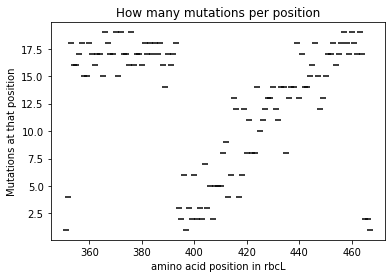

In [47]:
# Make a graph showing how many mutants I have at each position of the protein
# Ideally I would have 19 mutants at each position

def getMutPosition(mutation):
    return int(mutation[1:-1])

def getMutAA(mutation):
    return mutation[-1:]

foundMutPos = []
foundMutAA = []

for mutant in dfOnlyUniques['Single mutation']:
    if mutant != DUMMY_MUTATION:
        foundMutPos.append(getMutPosition(mutant))
        foundMutAA.append(getMutAA(mutant))
        
mutationPositionData = {'Position' : foundMutPos , 'Amino acid' : foundMutAA}
dfPositionAA = pd.DataFrame(mutationPositionData)
mutationsByPosition = dfPositionAA.groupby('Position')['Amino acid'].nunique()
dfPositionAAanalyzed = pd.DataFrame(mutationsByPosition)
dfPositionAAanalyzed.to_csv(FILE_NAME + '_mutationsByPosition.csv')

plt.scatter(x = dfPositionAAanalyzed.index, y = dfPositionAAanalyzed['Amino acid'], color = 'black', marker = '_')
plt.title('How many mutations per position')
plt.xlabel('amino acid position in rbcL')
plt.ylabel('Mutations at that position')
plt.savefig(FILE_NAME + '_mutationsByPosition.pdf')